# Demo of bboxconverter

This notebook demonstrates the use of the `bboxconverter` package.


## Converting bbox from CSV

In this example, we will convert a csv file containing bounding boxes in the format `tlwh` to `tlbr` and `cwh` formats.


In [1]:
import bboxconverter as bc

# Input file path
input_path1 = './examples/csv_convert_demo/example1_tlwh.csv'

# Output file path
output_tlbr = './examples/csv_convert_demo/example1_tlbr.csv'
output_cwh = './examples/csv_convert_demo/example1_cwh.csv'

# Mapping between the input file and the bboxconverter format
bbox_map = dict(
    class_name='class',
    file_path='name',
    x_min='top_left_x',
    y_min='top_left_y',
    width='w',
    height='h',
    image_width='img_size_x',
    image_height='img_size_y',
)

# Read the input file
parser = bc.read_csv(input_path1, mapping=bbox_map)

# Export the file to the desired format
parser.to_csv(output_path=output_tlbr, type='tlbr')
parser.to_csv(output_path=output_cwh, type='cwh')

print(f"File saved to {output_tlbr} and {output_cwh}")


File saved to ./examples/csv_convert_demo/example1_tlbr.csv and ./examples/csv_convert_demo/example1_cwh.csv


## Exporting FROM CSV to popular formats (COCO, VOC, YOLO)

In this example, we will convert a csv file containing bounding boxes in popular format like `COCO`, `VOC` and `YOLO` formats.

In [2]:
import bboxconverter as bc

# Input file path
input_path2 = './examples/csv_export_demo/example1_tlwh.csv'

# Output file path
output_coco = './examples/csv_export_demo/coco.json'
output_pascal_voc = './examples/csv_export_demo/pascal_voc.xml'
output_yolo = './examples/csv_export_demo/yolo.txt'

# Mapping between the input file and the bboxconverter format
bbox_map = dict(
    class_name='class',
    file_path='name',
    x_min='top_left_x',
    y_min='top_left_y',
    width='w',
    height='h',
    image_width='img_size_x',
    image_height='img_size_y',
)

# Read the input file
parser = bc.read_csv(input_path2, mapping=bbox_map)

# Export the file to the desired format
parser.export(output_path=output_coco, format='coco')
parser.export(output_path=output_pascal_voc, format='voc')
parser.export(output_path=output_yolo, format='yolo')


Not implemented yet
Not implemented yet


## Exporting from Manifest to common formats

In this example, we will convert a manifest file containing bounding boxes in popular format like `COCO`, `VOC` and `YOLO` formats.

In [3]:
import bboxconverter as bc

# Input file path
input_path2 = './examples/manifest_export_demo/example.manifest'

# Output file path
output_coco = './examples/manifest_export_demo/coco.json'
output_pascal_voc = './examples/manifest_export_demo/pascal_voc.xml'
output_yolo = './examples/manifest_export_demo/yolo.txt'

# Configuration of the manifest file
config = {
    'labelling-job-name': 'crh-label-test5',
    'labelling-job-metadata': 'crh-label-test5-metadata',
}

# Read the input file
parser = bc.read_manifest(input_path2, configuration=config)

# Export the file to the desired format
parser.export(output_path=output_coco, format='coco', split=True, train_size=0.8, test_size=0.2)
parser.export(output_path=output_pascal_voc, format='voc')
parser.export(output_path=output_yolo, format='yolo')


Not implemented yet
Not implemented yet


## Displaying bounding boxes

In this section we will display bounding boxes on images using pycocotools package.


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
COCO categories: 
cat dog



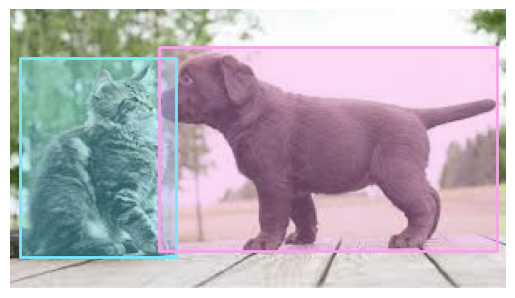

In [4]:
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
from pycocotools.coco import COCO

# Load COCO annotations
annFile = f'./examples/import_demo/coco/result.json'
coco = COCO(annFile)
cats = coco.loadCats(coco.getCatIds())
nms = [cat['name'] for cat in cats]
print(f'COCO categories: \n{" ".join(nms)}\n')

# Get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['cat', 'dog'])
imgIds = coco.getImgIds(catIds=catIds)
img = coco.loadImgs(imgIds[np.random.randint(0, len(imgIds))])[0]

# Load and display image
I = io.imread(
    f'examples/import_demo/coco/images/{img["file_name"].split("/")[-1]}'
)
plt.imshow(I)
plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox=True)
